In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import os, lzma, csv, bz2, io, collections, pickle, time
import pyproj
import tilemapbase
import shapely.geometry

import open_cp.sources.chicago

In [2]:
data_dir = os.path.join("/media", "disk", "Data")
#data_dir = os.path.join("..", "..", "..", "..", "Data")
#os.listdir(data_dir)
filename = os.path.join(data_dir, "chicago_all.csv.xz")

In [3]:
with lzma.open(filename, "rt", encoding="utf8") as f:
    reader = csv.reader(f)
    header = next(reader)
    out = collections.defaultdict(set)
    for row in reader:
        if row[15] == "":
            continue
        year = int(row[17])
        if year <= 2001:
            continue
        block, x, y = row[3], int(row[15]), int(row[16])
        #x /= open_cp.sources.chicago._FEET_IN_METERS
        #y /= open_cp.sources.chicago._FEET_IN_METERS
        if x < 100 or y < 100:
            continue
        out[block].add((x,y))

In [4]:
vertices, keys = [], []
for keyi, key in enumerate(out):
    keys.append(key)
    for i, pt in enumerate(out[key]):
        v = (keyi, i)
        vertices.append((v,pt))

In [5]:
out = None
import gc
gc.collect()

0

# Form the graph

In [34]:
import networkx as nx
import rtree

In [84]:
graph = nx.Graph()
for v, pt in vertices:
    graph.add_node(v)

In [9]:
h = 0.01
def gen():
    for i, (_, pt) in enumerate(vertices):
        x, y = pt
        xmin, xmax = x-h, x+h
        ymin, ymax = y-h, y+h
        yield i, (xmin,xmax,ymin,ymax), None

index = rtree.Rtree(gen(), interleaved=False)

In [85]:
# Units are feet at present
cutoff = 40
for v, (x,y) in vertices:
    d = cutoff * 1.5
    xmin, xmax = x-d, x+d
    ymin, ymax = y-d, y+d
    for j in index.intersection((xmin,xmax,ymin,ymax)):
        u, (xx,yy) = vertices[j]
        dist = np.sqrt((x-xx)**2 + (y-yy)**2)
        if u != v and dist <= cutoff:
            graph.add_edge(v, u)

In [86]:
len(vertices), graph.number_of_nodes(), graph.number_of_edges()

(681012, 681012, 2592474)

In [87]:
nx.number_connected_components(graph)

69135

# Save to shapefile

In [88]:
tree = nx.minimum_spanning_tree(graph)

In [89]:
lookup = { k : (x,y) for k, (x,y) in vertices }

In [90]:
geo = []
blocks = []
for (keyi, i), (keyj,j) in tree.edges_iter():
    block = "{} -- {}".format(keys[keyi], keys[keyj])
    blocks.append(block)
    x1,y1 = lookup[(keyi,i)]
    x2,y2 = lookup[(keyj,j)]
    x1 /= open_cp.sources.chicago._FEET_IN_METERS
    x2 /= open_cp.sources.chicago._FEET_IN_METERS
    y1 /= open_cp.sources.chicago._FEET_IN_METERS
    y2 /= open_cp.sources.chicago._FEET_IN_METERS
    geo.append( shapely.geometry.LineString([[x1,y1], [x2,y2]]) )

In [91]:
frame = gpd.GeoDataFrame({"blocks" : blocks})
frame.geometry = geo
frame.crs = {"init":"epsg:3528"}
frame.head()

,blocks,geometry
0,022XX N CANNON DR -- 022XX N CANNON DR,LINESTRING (358153.3997390912 583742.273320247...
1,022XX N CANNON DR -- 022XX N CANNON DR,LINESTRING (358153.3997390912 583742.273320247...
2,022XX N CANNON DR -- 022XX N CANNON DR,LINESTRING (358153.3997390912 583742.273320247...
3,022XX N CANNON DR -- 022XX N CANNON DR,LINESTRING (358154.9237390424 583736.177320442...
4,022XX N CANNON DR -- 022XX N CANNON DR,LINESTRING (358152.1805391302 583746.235720120...


In [92]:
frame.to_file("chicago_as_graph")

# Analysis

Need to remember that I _think_ the connected components do not include isolated vertices...

Result is that the input data is just very noisy.  Lots of overlap between adjacent blocks.  Lots of random points being in the wrong place.  Again with the NORTH/SOUTH mismatch

## Does each cluster have the same `block` name?

In [134]:
postfix = {" AV" : " AVE", "BL":"BLVD", "BV":"BLVD"}
remove_after_digits = {"TH", "ST", "ND", "RD"}

def normalise(block):
    block = block.upper()
    for f,t in postfix.items():
        if block.endswith(f):
            block = block[:-len(f)] + t
    for ps in remove_after_digits:
        while True:
            i = block.find(ps)
            if i == -1:
                break
            block = block[:i] + block[i+2:]
    for _ in range(10):
        block = block.replace("  ", " ")
    if block.startswith("0000X"):
        block = "000XX" + block[5:]
    return block.strip()
            
assert normalise("037XX N WILTON AV") == '037XX N WILTON AVE'
assert normalise("020XX W 70TH PL") == '020XX W 70 PL'
assert normalise('0000X W 79 ') == '000XX W 79'

In [135]:
x = "    70TH  aa 80TH"
x.replace("  ", " ")

'  70TH aa 80TH'

In [182]:
count = 0

for x in nx.connected_components(graph):
    keyset = set(normalise(keys[k]) for k,_ in x)
    if len(keyset) > 1:
        print(keyset)
        count += 1
        if count>=29: break

{'051XX S DAMEN AVE', '052XX S DAMEN AVE'}
{'000XX W DIVISION', '011XX N ATE'}
{'029XX N MILWAUKEE AVE', '028XX N MILWAUKEE AVE'}
{'029XX N MILWAUKEE AVE', '030XX N MILWAUKEE AVE'}
{'003XX W 94 PL', '093XX S EWART AVE'}
{'014XX N ASHLA AVE', '015XX N ASHLA AVE'}
{'109XX S VINCENNES AVE', '109XX S ASHLA AVE'}
{'001XX E 111', '114XX S MICHIGAN AVE'}
{'002XX N LOREL AVE', '003XX N LOREL AVE'}
{'070XX S ROOP REET', '070XX S ROOP'}
{'057XX S WOOD', '059XX S WOOD'}
{'083XX S COTTAGE GROVE', '083XX S COTTAGE GROVE AVE'}
{'060XX N BROADWAY', '061XX N BROADWAY'}
{'032XX W EISENHOWER EXPY IB', '032XX W EISENHOWER EXPY OB', '005XX S KEDZIE AVE'}
{'011XX W ADDISON', '010XX W ADDISON'}
{'045XX S IIANA AVE', '044XX S IIANA AVE'}
{'009XX W BELMONT AVE', '018XX W MONTROSE AVE'}
{'002XX W WASHINGTON', '002XX W WASHINGTON BLVD'}
{'052XX S LOOMIS', '052XX S LOOMIS BLVD'}
{'003XX W MONTROSE HARBOR DR', '002XX W MONTROSE HARBOR DR'}
{'076XX S YATES BLVD', '076XX S YATES AVE'}
{'060XX S DAMEN AVE', '063XX S

In [183]:
proj = pyproj.Proj({"init":"epsg:3528"})

In [184]:
k = list(x)[0]
x, y = lookup[k]
x /= open_cp.sources.chicago._FEET_IN_METERS
y /= open_cp.sources.chicago._FEET_IN_METERS
x, y = proj(x, y, inverse=True)
x, y

(-87.72510347271336, 41.86356264185516)

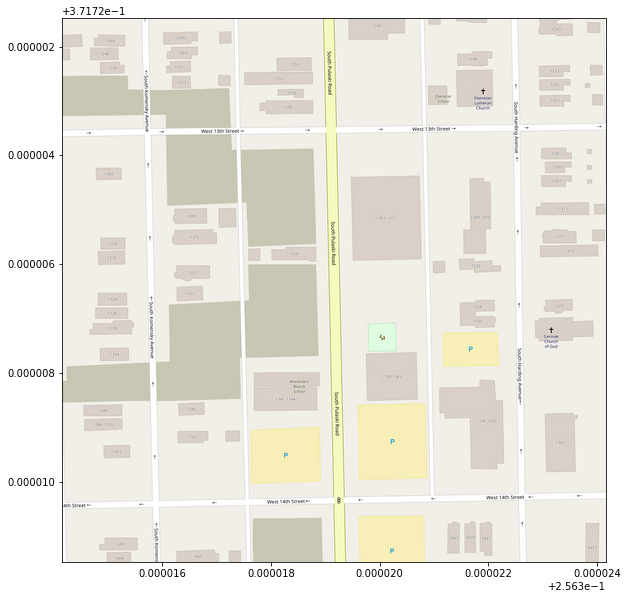

In [185]:
ex = tilemapbase.Extent.from_centre_lonlat(x,y,xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)

# Reassign

The idea now is to take a centroid of each "cluster" (not forgetting singleton vertices) as it's "location", assign every point to it's centroid, and then form a voroni diagram to randomly redistribute these.

In [214]:
remap = {}
for nodes in nx.connected_components(graph):
    pts = set(lookup[v] for v in nodes)
    cx, cy = np.mean(np.asarray(list(pts)), axis=0)
    for pt in pts:
        assert pt not in remap
        remap[pt] = (cx,cy)

In [215]:
for _, pt in vertices:
    if pt not in remap:
        remap[pt] = pt

In [216]:
centroids = np.asarray(list(set(remap.values())))
centroids.shape

(69135, 2)

In [217]:
import scipy.spatial
voroni = scipy.spatial.Voronoi(centroids)

In [218]:
def perp_direction(points, a, b):
    """Return (x,y) a vector which is pendicular to the line from point
    `a` to point `b` in `points`, orientated correctly, and of unit length.
    """
    x = points[b,0] - points[a,0]
    y = points[b,1] - points[a,1]
    n = np.sqrt(x*x + y*y)
    x, y = y/n, -x/n
    centre = np.mean(points, axis=0)
    midpoint = (points[a] + points[b]) / 2
    
    if np.dot(centre-midpoint, np.array([x,y])) <= 0:
        return x,y
    else:
        return -x,-y

In [219]:
inf_lines = {}
inf_dirs = {}
for ((a,b),(aa,bb)) in zip(voroni.ridge_vertices, voroni.ridge_points):
    if a == -1:
        sx, sy = voroni.vertices[b,0], voroni.vertices[b,1]
        x, y = perp_direction(voroni.points, aa, bb) 
        inf_dirs[b] = x, y
        inf_lines[b] = [sx, sx + x*2], [sy, sy + y*2]
    
voroni_polygons = []
for reg in voroni.regions:
    if len(reg) == 0:
        continue
    verts = [voroni.vertices[v] for v in reg]
    if -1 in reg:
        i = reg.index(-1)
        i_before, i_after = i-1, i+1
        if i_after == len(reg):
            i_after = 0
        i_before, i_after = reg[i_before], reg[i_after]
        xo, yo = voroni.vertices[i_after]
        xd, yd = inf_dirs[i_after]
        verts[i] = (xo+xd, yo+yd)
        #verts[i] = inf_lines[i_after][0][1], inf_lines[i_after][1][1]
        xo, yo = voroni.vertices[i_before]
        xd, yd = inf_dirs[i_before]
        verts.insert(i, (xo+xd, yo+yd))
        #verts.insert(i, (inf_lines[i_before][0][1], inf_lines[i_before][1][1]))
    voroni_polygons.append(verts)

In [220]:
import shapely.geometry

voroni_polygons = [shapely.geometry.Polygon(verts) for verts in voroni_polygons]

In [221]:
base = [[300, 525], [400,525], [400,625], [300,625]]
# Feet!
base = [ [x*open_cp.sources.chicago._FEET_IN_METERS, y*open_cp.sources.chicago._FEET_IN_METERS]
        for x,y in base]
base = [[x*1000,y*1000] for x,y in base]
base = shapely.geometry.Polygon(base)

voroni_polygons = [verts.intersection(base) for verts in voroni_polygons]

In [222]:
voroni_polygons = [list(verts.exterior.coords) for verts in voroni_polygons]

[(1850393.76, 1856955.4400000002), (1177821.5599999998, 1184383.24)]

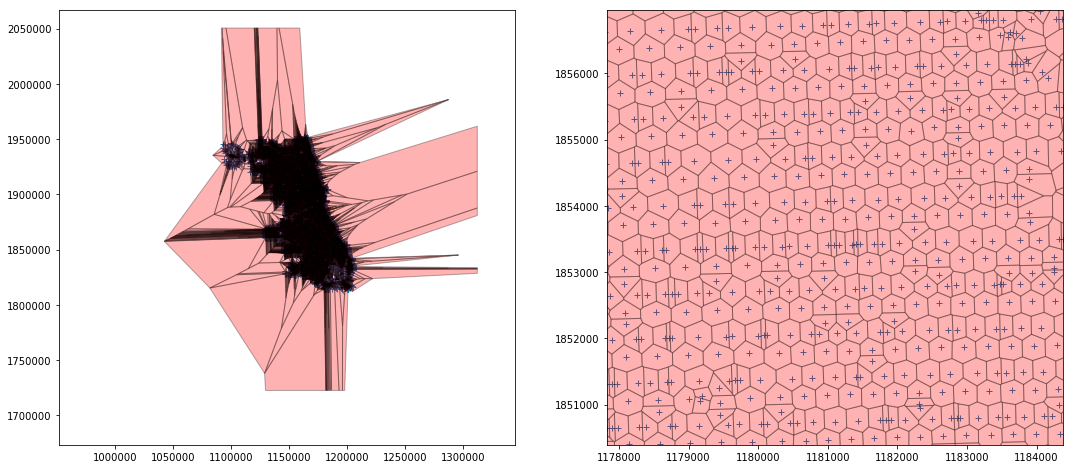

In [223]:
import matplotlib.patches

fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    ax.scatter(*voroni.points.T, marker="+", linewidth=1)
    for i, verts in enumerate(voroni_polygons):
        poly = matplotlib.patches.Polygon(verts, fc="red", alpha=0.3, ec="black")
        ax.add_patch(poly)
        
x, y, s = (350000*open_cp.sources.chicago._FEET_IN_METERS,
           570000*open_cp.sources.chicago._FEET_IN_METERS,
           60000*open_cp.sources.chicago._FEET_IN_METERS)
axes[0].set(xlim=[x-s,x+s], ylim=[y-s,y+s])
x, y, s = (360000*open_cp.sources.chicago._FEET_IN_METERS,
           565000*open_cp.sources.chicago._FEET_IN_METERS,
           1000*open_cp.sources.chicago._FEET_IN_METERS)
axes[1].set(xlim=[x-s,x+s], ylim=[y-s,y+s])

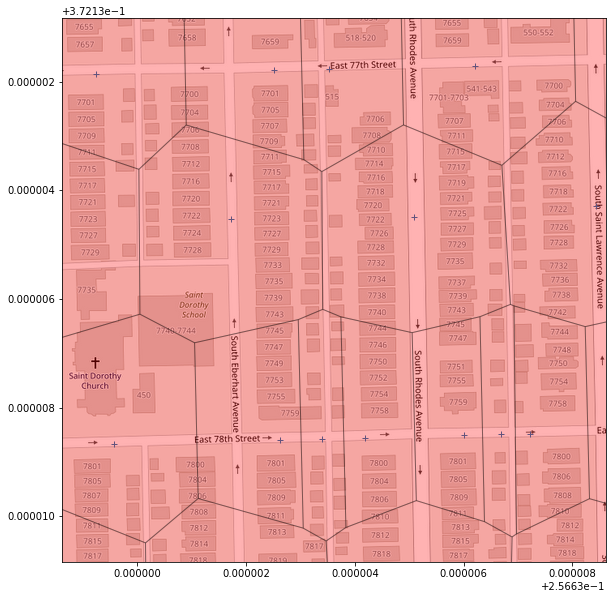

In [231]:
x, y = 360000, 565000
x, y = proj(x, y, inverse=True)

ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)

points = voroni.points / open_cp.sources.chicago._FEET_IN_METERS
xcs, ycs = proj(points[:,0], points[:,1], inverse=True)
xc, yc = [], []
for x, y in zip(xcs, ycs):
    x, y = tilemapbase.project(x, y)
    xc.append(x)
    yc.append(y)
ax.scatter(xc, yc, marker="+", linewidth=1)
for i, verts in enumerate(voroni_polygons):
    verts = np.asarray(verts) / open_cp.sources.chicago._FEET_IN_METERS
    xcs, ycs = proj(verts[:,0], verts[:,1], inverse=True)
    xc, yc = [], []
    for x, y in zip(xcs, ycs):
        x, y = tilemapbase.project(x, y)
        xc.append(x)
        yc.append(y)
    verts = list(zip(xc,yc))
    poly = matplotlib.patches.Polygon(verts, fc="red", alpha=0.3, ec="black")
    ax.add_patch(poly)

So the problem is that this isn't terribly realistic: single events can massively dominate at the expense of what we know to be repeated events.

**What would happen if we ran this on _just_ burglary events?**

## Don't use centroids

Can we interpolate instead?

In [250]:
centroids = []
assigned = set()
for nodes in nx.connected_components(graph):
    pts = set(lookup[v] for v in nodes)
    pts = np.asarray(list(pts))
    x, y = np.min(pts, axis=0)
    centroids.append((x,y))
    x, y = np.max(pts, axis=0)
    centroids.append((x,y))
    for x,y in pts:
        assigned.add((x,y))

In [251]:
for _, pt in vertices:
    if pt not in assigned:
        centroids.append(pt)

In [255]:
centroids = np.asarray(list(set(centroids)))
centroids.shape

(118326, 2)

In [256]:
voroni = scipy.spatial.Voronoi(centroids)

inf_lines = {}
inf_dirs = {}
for ((a,b),(aa,bb)) in zip(voroni.ridge_vertices, voroni.ridge_points):
    if a == -1:
        sx, sy = voroni.vertices[b,0], voroni.vertices[b,1]
        x, y = perp_direction(voroni.points, aa, bb) 
        inf_dirs[b] = x, y
        inf_lines[b] = [sx, sx + x*2], [sy, sy + y*2]
    
voroni_polygons = []
for reg in voroni.regions:
    if len(reg) == 0:
        continue
    verts = [voroni.vertices[v] for v in reg]
    if -1 in reg:
        i = reg.index(-1)
        i_before, i_after = i-1, i+1
        if i_after == len(reg):
            i_after = 0
        i_before, i_after = reg[i_before], reg[i_after]
        xo, yo = voroni.vertices[i_after]
        xd, yd = inf_dirs[i_after]
        verts[i] = (xo+xd, yo+yd)
        #verts[i] = inf_lines[i_after][0][1], inf_lines[i_after][1][1]
        xo, yo = voroni.vertices[i_before]
        xd, yd = inf_dirs[i_before]
        verts.insert(i, (xo+xd, yo+yd))
        #verts.insert(i, (inf_lines[i_before][0][1], inf_lines[i_before][1][1]))
    voroni_polygons.append(verts)

In [257]:
voroni_polygons = [shapely.geometry.Polygon(verts) for verts in voroni_polygons]
base = [[300, 525], [400,525], [400,625], [300,625]]
# Feet!
base = [ [x*open_cp.sources.chicago._FEET_IN_METERS, y*open_cp.sources.chicago._FEET_IN_METERS]
        for x,y in base]
base = [[x*1000,y*1000] for x,y in base]
base = shapely.geometry.Polygon(base)

voroni_polygons = [verts.intersection(base) for verts in voroni_polygons]

voroni_polygons = [list(verts.exterior.coords) for verts in voroni_polygons]

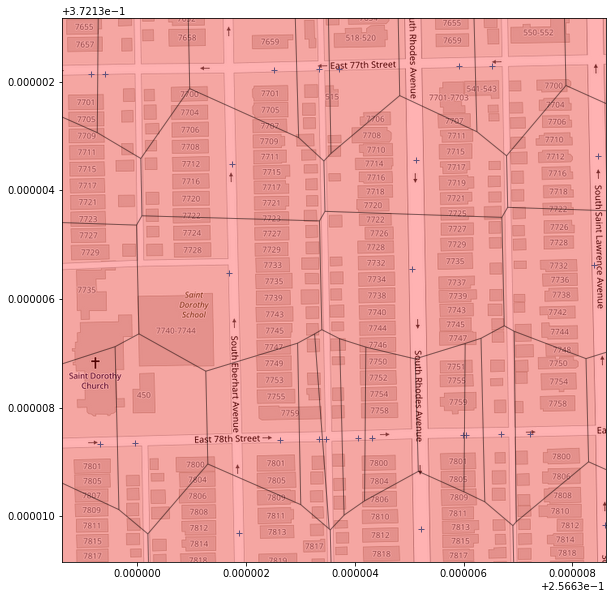

In [258]:
x, y = 360000, 565000
x, y = proj(x, y, inverse=True)

ex = tilemapbase.Extent.from_centre_lonlat(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=400)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)

points = voroni.points / open_cp.sources.chicago._FEET_IN_METERS
xcs, ycs = proj(points[:,0], points[:,1], inverse=True)
xc, yc = [], []
for x, y in zip(xcs, ycs):
    x, y = tilemapbase.project(x, y)
    xc.append(x)
    yc.append(y)
ax.scatter(xc, yc, marker="+", linewidth=1)
for i, verts in enumerate(voroni_polygons):
    verts = np.asarray(verts) / open_cp.sources.chicago._FEET_IN_METERS
    xcs, ycs = proj(verts[:,0], verts[:,1], inverse=True)
    xc, yc = [], []
    for x, y in zip(xcs, ycs):
        x, y = tilemapbase.project(x, y)
        xc.append(x)
        yc.append(y)
    verts = list(zip(xc,yc))
    poly = matplotlib.patches.Polygon(verts, fc="red", alpha=0.3, ec="black")
    ax.add_patch(poly)